In [2]:
import os
os.makedirs("current working directory", exist_ok=True)

print("Subfolder created successfully!")

Subfolder created successfully!


In [3]:
os.chdir("current working directory")   # Change to subfolder
print("Now in:", os.getcwd())


Now in: D:\Mcvs_clermont\current working directory


In [4]:
import pandas as pd

# Load the parquet file (replace with correct path if needed)
df = pd.read_csv("lightcurve_features_26_negative.parquet")

# View first few rows
df.head()


,object,mean,weighted_mean,standard_deviation,median,amplitude,beyond_1_std,cusum,inter_percentile_range_10,kurtosis,...,magnitude_percentage_ratio_20_10,maximum_slope,median_absolute_deviation,median_buffer_range_percentage_10,percent_amplitude,mean_variance,anderson_darling_normal,chi2,skew,stetson_K
0,ZTF17aaatdnl,16.474019,16.265769,0.655889,16.159328,2.216342,0.108881,0.239616,1.121193,5.080193,...,0.476100,896.175436,0.054062,0.681265,3.304615,0.039814,241.291275,454.107709,2.385774,0.765791
1,ZTF18aaawejy,16.510358,16.406240,0.425248,16.273313,1.010284,0.195536,0.356777,1.111182,0.273401,...,0.593552,669.958263,0.060773,0.612500,1.315850,0.025756,259.973064,541.683306,1.310183,0.795163
2,ZTF18aaphvtk,17.344563,16.750839,0.729764,17.723148,1.856989,0.135151,0.299635,1.655165,3.076823,...,0.457040,596.780858,0.153105,0.516301,3.273998,0.042075,169.896297,2942.566563,-1.916860,0.796064
3,ZTF18aawadfc,14.772833,14.772367,0.083390,14.770324,0.325024,0.556935,0.343321,0.204603,-0.675172,...,0.912447,888.048458,0.088786,0.202914,0.456098,0.005645,66.631091,49.674484,0.147798,0.887305
4,ZTF18aawccls,17.244160,17.142604,0.398646,17.278309,1.159980,0.431990,0.212555,1.089173,-0.760558,...,0.771138,519.031189,0.326796,0.287154,1.180918,0.023118,13.502721,328.469899,-0.108506,0.824070


In [5]:
id_col = "object"   # change this to your actual unique column name

# Check for duplicates
dupes = df[df.duplicated(subset=[id_col], keep=False)]

print("Total duplicates found:", len(dupes))

# View first few duplicate entries
dupes.sort_values(by=id_col).head(10)


Total duplicates found: 0


,object,mean,weighted_mean,standard_deviation,median,amplitude,beyond_1_std,cusum,inter_percentile_range_10,kurtosis,...,magnitude_percentage_ratio_20_10,maximum_slope,median_absolute_deviation,median_buffer_range_percentage_10,percent_amplitude,mean_variance,anderson_darling_normal,chi2,skew,stetson_K


In [6]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN #utilizing DBSCAN for density-based clustering
from sklearn.preprocessing import StandardScaler # It transforms data such that it has a mean of 0 and a standard deviation of 1

# 1️⃣ Load your negative sample
df_neg = pd.read_csv("lightcurve_features_26_negative.parquet")





In [7]:
features = df_neg.select_dtypes(include=[np.number]) #nonnumericals are dropped


In [8]:
features = features.replace([np.inf, -np.inf], np.nan)
features = features.dropna()


In [9]:
features = df_neg.select_dtypes(include=[np.number])
X = StandardScaler().fit_transform(features) #standardize and transforming features


In [10]:
#  Cluster with DBSCAN
db = DBSCAN(eps=2.36, min_samples=5).fit(X)
df_neg["cluster"] = db.labels_

In [11]:
# Check number of clusters (excluding noise = -1)
clusters = [c for c in np.unique(db.labels_) if c != -1]
print(f"Found {len(clusters)} clusters: {clusters}")


Found 11 clusters: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [12]:
labels = db.labels_
print("Unique labels:", np.unique(labels))
print("Noise points:", np.sum(labels == -1))
print("Non-noise points:", np.sum(labels != -1))


Unique labels: [-1  0  1  2  3  4  5  6  7  8  9 10]
Noise points: 366
Non-noise points: 1105


In [25]:
import pandas as pd
import os

# === Create output folder ===
os.makedirs("cluster_groups", exist_ok=True)

# ===  Separate clusters and noise ===
clustered = df_neg[df_neg['cluster'] != -1]   # clustered data
noise = df_neg[df_neg['cluster'] == -1]       # noise data

# ===  Count elements per cluster ===
cluster_counts = clustered['cluster'].value_counts().sort_index()
print("Distribution of elements per cluster:")
print(cluster_counts)

# ===  Save each cluster into a separate file ===
for c in sorted(clustered['cluster'].unique()):
    subset = clustered[clustered['cluster'] == c]
    filename = f"cluster_groups_{c}.parquet"
    subset.to_parquet(filename, index=False)
    print(f"Saved {len(subset)} elements to {filename}")

# ===  Save noise elements ===
noise_filename = "cluster_groups_noise.parquet"
noise.to_parquet(noise_filename, index=False)
print(f"Saved {len(noise)} noise elements to {noise_filename}")

# ===  Optional summary file ===
summary = pd.DataFrame({
    'cluster': cluster_counts.index,
    'count': cluster_counts.values
})
summary.to_csv("cluster_summary.csv", index=False)
print("\nCluster summary saved to cluster_groups/cluster_summary.csv")


Distribution of elements per cluster:
cluster
0        7
1     1032
2       19
3        7
4        5
5        5
6        6
7        5
8        8
9        4
10       7
Name: count, dtype: int64
Saved 7 elements to cluster_groups_0.parquet
Saved 1032 elements to cluster_groups_1.parquet
Saved 19 elements to cluster_groups_2.parquet
Saved 7 elements to cluster_groups_3.parquet
Saved 5 elements to cluster_groups_4.parquet
Saved 5 elements to cluster_groups_5.parquet
Saved 6 elements to cluster_groups_6.parquet
Saved 5 elements to cluster_groups_7.parquet
Saved 8 elements to cluster_groups_8.parquet
Saved 4 elements to cluster_groups_9.parquet
Saved 7 elements to cluster_groups_10.parquet
Saved 366 noise elements to cluster_groups_noise.parquet

Cluster summary saved to cluster_groups/cluster_summary.csv


In [26]:
import pandas as pd
import random
import glob
import os
# === Step 1: Set working directory ===
cluster_dir = r"D:\Mcvs_clermont\current working directory\cluster_groups"
os.chdir(cluster_dir)

In [31]:
# === Step 2: Read all cluster parquet files (excluding noise) ===
cluster_files = sorted(glob.glob(r"D:\Mcvs_clermont\current working directory\cluster_groups\cluster_groups_*.parquet"))
cluster_files = [f for f in cluster_files if "noise" not in f]

In [33]:
import glob
import os

cluster_dir = r"D:\Mcvs_clermont\current working directory\cluster_groups"
os.chdir(cluster_dir)

files = glob.glob("*.parquet")
print("Found files:", files)


Found files: ['cluster_0.parquet', 'cluster_1.parquet', 'cluster_10.parquet', 'cluster_12_noise.parquet', 'cluster_2.parquet', 'cluster_3.parquet', 'cluster_4.parquet', 'cluster_5.parquet', 'cluster_6.parquet', 'cluster_7.parquet', 'cluster_8.parquet', 'cluster_9.parquet', 'noise.parquet']


In [3]:
import pandas as pd
import random
import glob
import os
# === Step 1: Set working directory ===
cluster_dir = r"D:\Mcvs_clermont\current working directory\cluster_groups"
os.chdir(cluster_dir)

In [8]:
# === Step 2: Read all cluster parquet files (excluding noise) ===
cluster_files = sorted(glob.glob(r"D:\Mcvs_clermont\current working directory\cluster_groups\cluster_*.parquet"))
cluster_files = [f for f in cluster_files if "noise" not in f]

In [9]:
clusters = []
for f in cluster_files:
    try:
        df = pd.read_parquet(f)
        if len(df) == 0:
            print(f"Skipping {f} (empty)")
            continue
        df["cluster_id"] = f.split("_")[-1].split(".")[0]
        clusters.append(df)
        print(f" Loaded {f} with {len(df)} rows")
    except Exception as e:
        print(f" Could not read {f}: {e}")

    

 Loaded D:\Mcvs_clermont\current working directory\cluster_groups\cluster_0.parquet with 7 rows
 Loaded D:\Mcvs_clermont\current working directory\cluster_groups\cluster_1.parquet with 1032 rows
 Loaded D:\Mcvs_clermont\current working directory\cluster_groups\cluster_10.parquet with 7 rows
 Loaded D:\Mcvs_clermont\current working directory\cluster_groups\cluster_2.parquet with 19 rows
 Loaded D:\Mcvs_clermont\current working directory\cluster_groups\cluster_3.parquet with 7 rows
 Loaded D:\Mcvs_clermont\current working directory\cluster_groups\cluster_4.parquet with 5 rows
 Loaded D:\Mcvs_clermont\current working directory\cluster_groups\cluster_5.parquet with 5 rows
 Loaded D:\Mcvs_clermont\current working directory\cluster_groups\cluster_6.parquet with 6 rows
 Loaded D:\Mcvs_clermont\current working directory\cluster_groups\cluster_7.parquet with 5 rows
 Loaded D:\Mcvs_clermont\current working directory\cluster_groups\cluster_8.parquet with 8 rows
 Loaded D:\Mcvs_clermont\current wo

In [10]:
#if not clusters:
 #   raise ValueError("No valid cluster files found or all were empty!")

all_data = pd.concat(clusters, ignore_index=True)
print(f"\nTotal combined elements: {len(all_data)}")



Total combined elements: 1105


In [11]:
# === Step 3: Shuffle all elements ===
all_data = all_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
# === Step 4: Split into 13 groups (each with 85 elements) ===
group_size = 85
groups = [all_data.iloc[i*group_size:(i+1)*group_size] for i in range(13)]

In [15]:
# === Step 5: Save each group ===
for i, g in enumerate(groups):
    out_file = os.path.join(cluster_dir, f"negative_subset_group_{i+1}.parquet")
    g.to_parquet(out_file, index=False)
    print(f"Saved {len(g)} elements to {out_file}")

Saved 85 elements to D:\Mcvs_clermont\current working directory\cluster_groups\negative_subset_group_1.parquet
Saved 85 elements to D:\Mcvs_clermont\current working directory\cluster_groups\negative_subset_group_2.parquet
Saved 85 elements to D:\Mcvs_clermont\current working directory\cluster_groups\negative_subset_group_3.parquet
Saved 85 elements to D:\Mcvs_clermont\current working directory\cluster_groups\negative_subset_group_4.parquet
Saved 85 elements to D:\Mcvs_clermont\current working directory\cluster_groups\negative_subset_group_5.parquet
Saved 85 elements to D:\Mcvs_clermont\current working directory\cluster_groups\negative_subset_group_6.parquet
Saved 85 elements to D:\Mcvs_clermont\current working directory\cluster_groups\negative_subset_group_7.parquet
Saved 85 elements to D:\Mcvs_clermont\current working directory\cluster_groups\negative_subset_group_8.parquet
Saved 85 elements to D:\Mcvs_clermont\current working directory\cluster_groups\negative_subset_group_9.parquet
S

In [14]:
# === Optional: Check cluster distribution in each group ===
for i, g in enumerate(groups):
    print(f"\nGroup {i+1} cluster counts:")
    print(g["cluster_id"].value_counts())


Group 1 cluster counts:
cluster_id
1     80
10     1
8      1
6      1
2      1
4      1
Name: count, dtype: int64

Group 2 cluster counts:
cluster_id
1    84
8     1
Name: count, dtype: int64

Group 3 cluster counts:
cluster_id
1    76
2     3
0     3
4     1
8     1
5     1
Name: count, dtype: int64

Group 4 cluster counts:
cluster_id
1    83
3     1
2     1
Name: count, dtype: int64

Group 5 cluster counts:
cluster_id
1    78
2     2
0     1
4     1
6     1
3     1
9     1
Name: count, dtype: int64

Group 6 cluster counts:
cluster_id
1    76
2     4
3     3
5     1
0     1
Name: count, dtype: int64

Group 7 cluster counts:
cluster_id
1    81
9     1
8     1
4     1
2     1
Name: count, dtype: int64

Group 8 cluster counts:
cluster_id
1    82
6     1
2     1
3     1
Name: count, dtype: int64

Group 9 cluster counts:
cluster_id
1     80
10     1
2      1
6      1
5      1
9      1
Name: count, dtype: int64

Group 10 cluster counts:
cluster_id
1     75
7      3
10     3
4      1
3    

In [18]:
import pandas as pd

# Load the parquet file (replace with correct path if needed)
df_cluster = pd.read_parquet(r"D:\Mcvs_clermont\current working directory\cluster_groups\negtive_subset_group_14_noise.parquet")

# View first few rows
df_cluster.head(1032)
print(df_cluster.shape)


(366, 28)


In [19]:
import pandas as pd

# Load the parquet file (replace with correct path if needed)
df_cluster = pd.read_parquet(r"D:\Mcvs_clermont\current working directory\cluster_groups\cluster_1.parquet")

# View first few rows
df_cluster.head(1032)
print(df_cluster.shape)


(1032, 28)


In [21]:
import pandas as pd
import numpy as np
import glob

# Find all 12 parquet files
neg_files = sorted(glob.glob("negative_subset_group*.parquet"))
# Store sampled dataframes
sampled_list = []
# Sample 35 rows from each subset
for f in neg_files:
    df = pd.read_parquet(f)
# Randomly sample 35 rows (or all if file has <10)
    #n = min(100, len(df))
    #n=max(100, len(df))
    n=len(df)
    print(n)
    sampled = df.sample(n, random_state=42)
    sampled_list.append(sampled)
    #print(f"Sampled {n} rows from {f}"
combined_df = pd.concat(sampled_list, ignore_index=True)
# Shuffle the combined data 
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
# Save to new parquet
combined_df.to_parquet("negative_combined_all.parquet", index=False)


85
85
85
85
85
366
85
85
85
85
85
85
85
85


In [23]:
import pandas as pd

# Load both files
df_parquet = pd.read_parquet("negative_combined_all.parquet")
df_csv = pd.read_csv("positive_100_elements.csv")
combined = pd.concat([df_parquet, df_csv], ignore_index=True)
combined.to_parquet("subset of baseline with allneg & pos.parquet", index=False)

print("Combined and shuffled dataset saved as 'subset of baseline with allneg & pos.parquet'")
print("Total rows:", len(combined))


Combined and shuffled dataset saved as 'subset of baseline with allneg & pos.parquet'
Total rows: 1571


In [38]:
dup_count = combined.duplicated(subset="object").sum()
print(f"Total duplicate IDs: {dup_count}")

Total duplicate IDs: 0


In [41]:
df_combined_baseline_subset_all = pd.read_parquet("subset of baseline with allneg & pos.parquet")
features_combined_baseline_subset_all = df_combined_baseline_subset_all .drop(columns=['object','cluster','cluster_id'])#errors='ignore')
features_combined_baseline_subset_all_numeric = features_combined_baseline_subset_all.select_dtypes(include='number')
corr_combined_baseline_subset_all = features_combined_baseline_subset_all_numeric.corr()

In [43]:
features_combined_baseline_subset_all

,mean,weighted_mean,standard_deviation,median,amplitude,beyond_1_std,cusum,inter_percentile_range_10,kurtosis,linear_trend,...,magnitude_percentage_ratio_20_10,maximum_slope,median_absolute_deviation,median_buffer_range_percentage_10,percent_amplitude,mean_variance,anderson_darling_normal,chi2,skew,stetson_K
0,13.602756,13.600786,0.194167,13.551601,1.594529,0.289233,0.235493,0.475948,21.593521,0.000099,...,0.691962,219.923903,0.088227,0.675258,2.727737,0.014274,49.220222,247.748572,2.059456,0.775113
1,15.655397,15.658733,0.238821,15.638908,0.669037,0.248913,0.253131,0.456102,1.399115,-0.000108,...,0.842541,219.414192,0.146764,0.112500,0.844150,0.015255,53.605864,154.069571,-0.812027,0.820224
2,15.917386,15.915512,0.098416,15.912807,0.389504,0.495868,0.381108,0.246597,-1.035860,-0.000090,...,0.867072,584.065041,0.095315,0.196143,0.434883,0.006183,51.271482,31.394575,0.174029,0.885085
3,16.087413,16.085389,0.086521,16.053020,0.543823,0.349215,0.395872,0.218258,1.683706,0.000077,...,0.791616,359.137470,0.052219,0.517596,0.744381,0.005378,64.653136,32.439946,0.706887,0.869402
4,18.284940,17.232688,1.134601,18.868792,2.270712,0.361605,0.292773,3.069963,-0.884689,0.000169,...,0.634668,551.500895,0.657377,0.363324,3.056760,0.062051,70.756626,821.288483,-0.586882,0.903019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1566,16.905293,16.891739,0.130254,16.905872,0.641553,0.319716,0.146000,0.328610,0.831722,0.000015,...,0.673249,679.331641,0.087836,0.388099,0.741325,0.007705,0.198451,59.169751,-0.083027,0.789198
1567,19.227544,18.342081,0.989385,19.060970,2.745060,0.425414,0.429222,2.542357,-1.123188,0.001677,...,0.796496,789.621964,0.868201,0.143646,2.862148,0.051457,16.202306,199.179353,0.269137,0.853870
1568,15.869141,15.860906,0.180194,15.848884,1.344455,0.201835,0.180301,0.363799,34.378112,-0.000084,...,0.628867,2868.198512,0.094182,0.677982,2.232877,0.011355,19.465335,79.962911,3.661152,0.732837
1569,18.458933,17.494483,0.926653,18.622186,1.716861,0.440613,0.290478,2.460330,-1.174519,-0.000023,...,0.813309,848.642852,0.697933,0.159004,1.914783,0.050201,10.833990,352.659253,-0.240478,0.948347


In [42]:
df_combined_baseline_subset_all

,object,mean,weighted_mean,standard_deviation,median,amplitude,beyond_1_std,cusum,inter_percentile_range_10,kurtosis,...,median_absolute_deviation,median_buffer_range_percentage_10,percent_amplitude,mean_variance,anderson_darling_normal,chi2,skew,stetson_K,cluster,cluster_id
0,ZTF18abachuh,13.602756,13.600786,0.194167,13.551601,1.594529,0.289233,0.235493,0.475948,21.593521,...,0.088227,0.675258,2.727737,0.014274,49.220222,247.748572,2.059456,0.775113,1.0,1
1,ZTF18abebodz,15.655397,15.658733,0.238821,15.638908,0.669037,0.248913,0.253131,0.456102,1.399115,...,0.146764,0.112500,0.844150,0.015255,53.605864,154.069571,-0.812027,0.820224,1.0,1
2,ZTF18aaxyujl,15.917386,15.915512,0.098416,15.912807,0.389504,0.495868,0.381108,0.246597,-1.035860,...,0.095315,0.196143,0.434883,0.006183,51.271482,31.394575,0.174029,0.885085,1.0,1
3,ZTF18abfjmbl,16.087413,16.085389,0.086521,16.053020,0.543823,0.349215,0.395872,0.218258,1.683706,...,0.052219,0.517596,0.744381,0.005378,64.653136,32.439946,0.706887,0.869402,1.0,1
4,ZTF18aayofec,18.284940,17.232688,1.134601,18.868792,2.270712,0.361605,0.292773,3.069963,-0.884689,...,0.657377,0.363324,3.056760,0.062051,70.756626,821.288483,-0.586882,0.903019,9.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1566,V418 Gem,16.905293,16.891739,0.130254,16.905872,0.641553,0.319716,0.146000,0.328610,0.831722,...,0.087836,0.388099,0.741325,0.007705,0.198451,59.169751,-0.083027,0.789198,NaN,None
1567,V677 And,19.227544,18.342081,0.989385,19.060970,2.745060,0.425414,0.429222,2.542357,-1.123188,...,0.868201,0.143646,2.862148,0.051457,16.202306,199.179353,0.269137,0.853870,NaN,None
1568,V2306 Cyg,15.869141,15.860906,0.180194,15.848884,1.344455,0.201835,0.180301,0.363799,34.378112,...,0.094182,0.677982,2.232877,0.011355,19.465335,79.962911,3.661152,0.732837,NaN,None
1569,IL Leo,18.458933,17.494483,0.926653,18.622186,1.716861,0.440613,0.290478,2.460330,-1.174519,...,0.697933,0.159004,1.914783,0.050201,10.833990,352.659253,-0.240478,0.948347,NaN,None


In [44]:
import pandas as pd

# Load both files
df_parquet = pd.read_csv("lightcurve_features_26_negative.parquet")
df_csv = pd.read_csv("positive_100_elements.csv")

In [45]:
combined = pd.concat([df_parquet, df_csv], ignore_index=True)

# Shuffle all rows
combined = combined.sample(frac=1, random_state=42).reset_index(drop=True)

In [46]:
combined.to_parquet("baseline set with all neg and 100 pos.parquet", index=False)

print("Combined and shuffled dataset saved as 'baseline set with all neg and 100 pos.parquet'")
print("Total rows:", len(combined))

Combined and shuffled dataset saved as 'baseline set with all neg and 100 pos.parquet'
Total rows: 1571


In [47]:
import pandas as pd
df_combined_baseline = pd.read_parquet("baseline set with all neg and 100 pos.parquet")
features_combined_baseline = df_combined_baseline .drop(columns=['object'])
features_combined_baseline_numeric = features_combined_baseline.select_dtypes(include='number')
corr_combined_baseline = features_combined_baseline_numeric.corr()

In [48]:
df_combined_baseline

,object,mean,weighted_mean,standard_deviation,median,amplitude,beyond_1_std,cusum,inter_percentile_range_10,kurtosis,...,magnitude_percentage_ratio_20_10,maximum_slope,median_absolute_deviation,median_buffer_range_percentage_10,percent_amplitude,mean_variance,anderson_darling_normal,chi2,skew,stetson_K
0,ZTF18abbrikh,16.104658,16.079719,0.275773,16.110229,0.691751,0.280480,0.223662,0.665586,-0.943915,...,0.744480,651.894741,0.228996,0.087176,0.706575,0.017124,34.641464,286.046599,-0.114433,0.886735
1,ZTF18aayofec,18.284940,17.232688,1.134601,18.868792,2.270712,0.361605,0.292773,3.069963,-0.884689,...,0.634668,551.500895,0.657377,0.363324,3.056760,0.062051,70.756626,821.288483,-0.586882,0.903019
2,ZTF18aazfeju,15.171564,15.159009,0.181192,15.170848,0.650220,0.278806,0.187474,0.406838,-0.250757,...,0.784730,739.187643,0.147596,0.161692,0.830567,0.011943,33.423127,78.529824,0.226995,0.844526
3,ZTF18adjmyuq,15.976566,15.951539,0.214719,15.986678,0.833680,0.386419,0.210536,0.489179,-0.491081,...,0.867378,706.746592,0.187393,0.219078,1.047107,0.013440,36.218583,195.238960,0.065449,0.856172
4,ZTF20aanlcpd,18.650733,18.591911,0.214695,18.737732,0.522768,0.343625,0.425178,0.569489,-0.806568,...,0.710384,369.599590,0.083839,0.367639,0.566807,0.011511,90.759503,27.144515,-0.597097,0.904202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1566,ZTF18abrrzeq,17.364388,17.335678,0.202778,17.408093,0.858205,0.316740,0.308967,0.570480,1.000957,...,0.488363,583.165123,0.087821,0.497265,1.072328,0.011678,35.709418,76.886510,0.121359,0.795542
1567,ZTF18abjartz,16.276459,16.266405,0.187004,16.227710,0.883832,0.314081,0.224566,0.520515,0.647527,...,0.595561,333.049997,0.083885,0.509351,1.255658,0.011489,49.548507,76.328801,0.526362,0.772414
1568,ZTF18abareij,16.179850,16.174791,0.140425,16.186563,0.568323,0.325492,0.163742,0.365974,0.630992,...,0.642558,1108.935013,0.080962,0.441466,0.653109,0.008679,27.279678,59.177617,-0.531466,0.728493
1569,ZTF18abdktfs,15.533986,15.508577,0.411432,15.650111,1.141420,0.320052,0.170971,1.042116,-0.451241,...,0.677081,1797.235556,0.328679,0.251470,1.153958,0.026486,12.211495,423.258197,-0.130320,0.852060


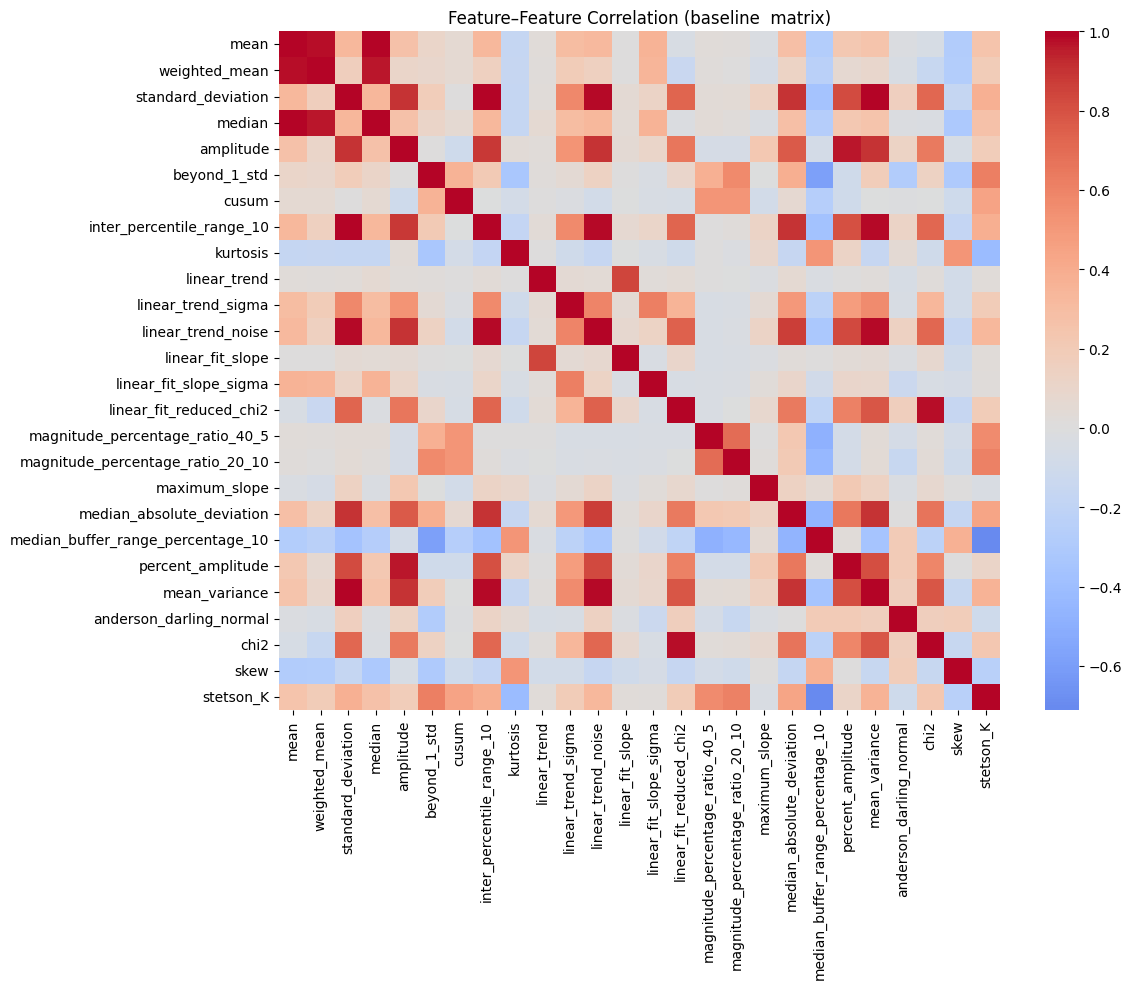

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_combined_baseline, cmap='coolwarm', center=0)
plt.title('Feature–Feature Correlation (baseline  matrix)')
plt.tight_layout()
plt.show()

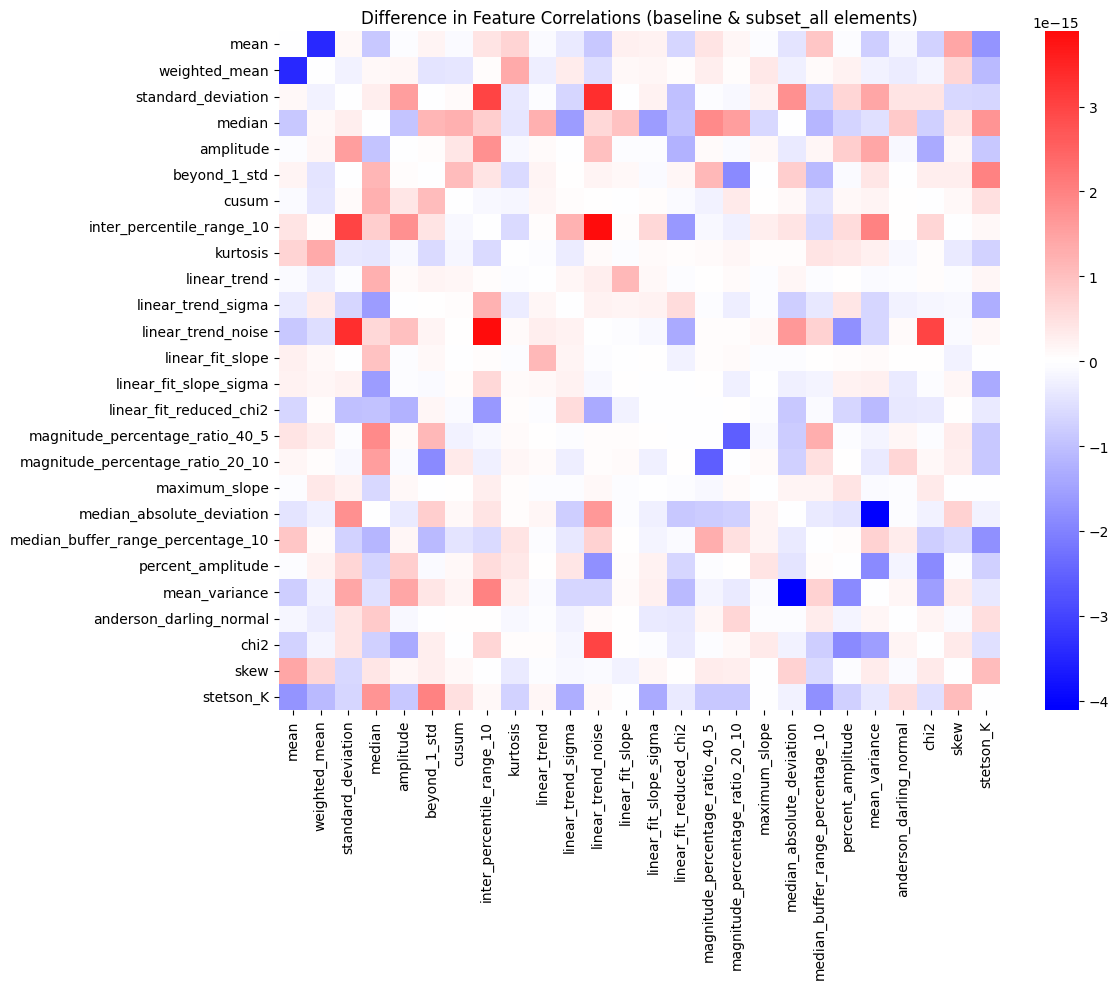

In [49]:
# corr_cv and corr_neg are correlation matrices
corr_diff_1 = corr_combined_baseline_subset_all - corr_combined_baseline
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_diff_1, cmap='bwr', center=0)
plt.title('Difference in Feature Correlations (baseline & subset_all elements)')
plt.tight_layout()
plt.show()



Total duplicates found: 898
Duplicate details saved to duplicate_objects_across_groups.csv
